<a href="https://colab.research.google.com/github/ManishPrasad0511/gw_open_data_workshop_2022/blob/main/challenge_3_and_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img style="float: left;padding: 1.3em" src="https://raw.githubusercontent.com/gw-odw/odw-2022/main/Tutorials/logo.png">  

#  Gravitational Wave Open Data Workshop #5


#### Tutorial 1.1: Discovering open data from GW observatories

This notebook describes how to discover what data are available from the [Gravitational-Wave Open Science Center (GWOSC)](https://www.gw-openscience.org).
    
[Click this link to view this tutorial in Google Colaboratory](https://colab.research.google.com/github/gw-odw/odw-2022/blob/main/Tutorials/Day_1/Tuto%201.1%20Discovering%20Open%20Data.ipynb)

In [1]:
! pip install -q lalsuite
! pip install -q gwpy
! pip install -q pycbc

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass, lowpass
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.waveform import get_td_waveform
from pycbc.filter import matched_filter
from pycbc import frame
import pylab
!pip install matplotlib==3.2.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.2.2-cp37-cp37m-manylinux1_x86_64.whl (12.4 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.2
    Uninstalling matplotlib-3.5.2:
      Successfully uninstalled matplotlib-3.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gwpy 2.1.3 requires matplotlib>=3.3.0, but you have matplotlib 3.2.2 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


## Challenge 3

## Challenge 3 H1 data

In [3]:
# -- download data
! wget https://www.gw-openscience.org/s/workshop3/challenge/challenge3.gwf

--2022-06-27 12:39:56--  https://www.gw-openscience.org/s/workshop3/challenge/challenge3.gwf
Resolving www.gw-openscience.org (www.gw-openscience.org)... 131.215.113.73
Connecting to www.gw-openscience.org (www.gw-openscience.org)|131.215.113.73|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 256815066 (245M)
Saving to: ‘challenge3.gwf.1’

challenge3.gwf.1    100%[===================>] 244.92M   107MB/s    in 2.3s    

2022-06-27 12:39:58 (107 MB/s) - ‘challenge3.gwf.1’ saved [256815066/256815066]



In [4]:
pycbc_strain_3 = frame.read_frame('challenge3.gwf.1', 'H1:CHALLENGE3')

`datasets.find_datasets` also accepts a `segment` and `detector` keyword to narrow results based on GPS time and detector:

In [ ]:
ts = pycbc_strain_3
data = resample_to_delta_t(ts, 1.0/2048)

p = data.psd(2)
p = interpolate(p, data.delta_f)
p = inverse_spectrum_truncation(p, int(2 * data.sample_rate), low_frequency_cutoff=15.0)
psd = p
H1_psd = psd

No handles with labels found to put in legend.


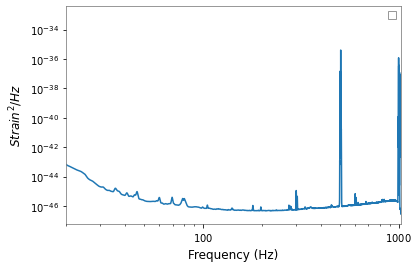

In [53]:
import pylab

pylab.plot(psd.sample_frequencies, psd) 
pylab.yscale('log')
pylab.xscale('log')
pylab.xlim(20, 1024)
pylab.ylabel('$Strain^2 / Hz$')
pylab.xlabel('Frequency (Hz)')
pylab.grid()
pylab.legend()
pylab.show()

In [6]:
import gwpy
from gwpy.timeseries import TimeSeries
gwpy_strain_3_gwpy = TimeSeries.read('challenge3.gwf.1', channel="H1:CHALLENGE3")

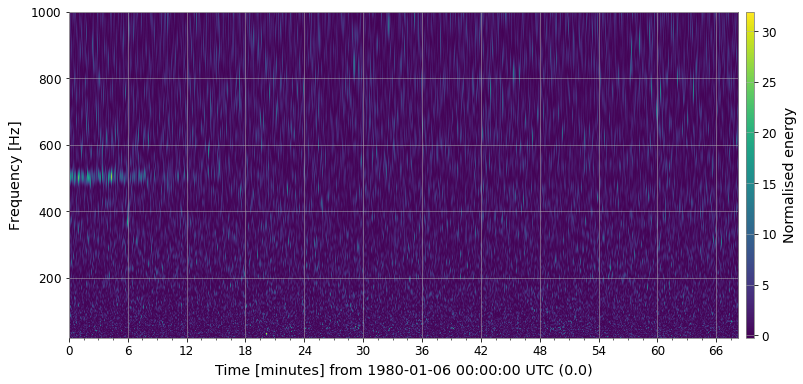

In [7]:
gwpy_strain_3_gwpy_q = gwpy_strain_3_gwpy.q_transform(frange=(20, 1000),qrange=(40,50))
plot = gwpy_strain_3_gwpy_q.plot()
ax = plot.gca()
ax.colorbar(label="Normalised energy")

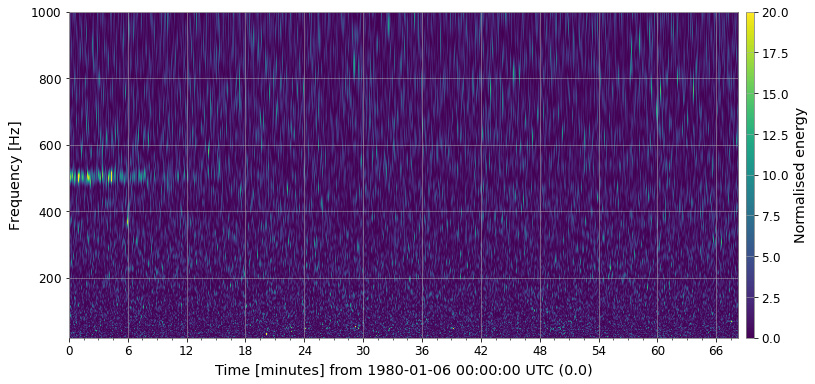

In [8]:
plot.colorbars[0].mappable.set_clim(0,20)
plot.refresh()
plot

Text(0, 0.5, 'Strain')

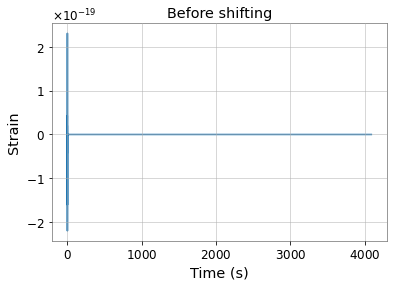

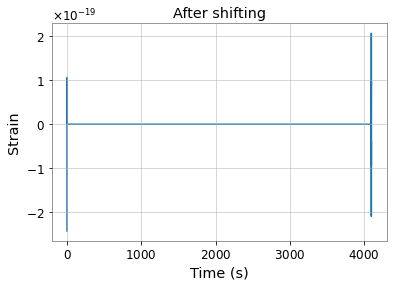

In [9]:
m = 10
conditioned = data
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
mass1=m,
mass2=m,
delta_t=conditioned.delta_t,
f_lower=20)
hp.resize(len(conditioned))
template = hp.cyclic_time_shift(hp.start_time)

pylab.figure()
pylab.title('Before shifting')
pylab.plot(hp.sample_times, hp)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

pylab.figure()
pylab.title('After shifting')
pylab.plot(template.sample_times, template)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')


Text(0, 0.5, 'Strain')

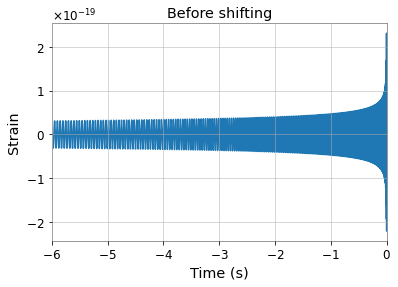

In [10]:
pylab.figure()
pylab.title('Before shifting')
pylab.plot(hp.sample_times, hp)
pylab.xlim(-6, 0)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

In [11]:
snr = matched_filter(template, conditioned, psd=psd, low_frequency_cutoff=20)
snr = snr.crop(4 + 4, 4)

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("Mass: {}. We found a signal at {}s with SNR {}".format(m, time, abs(snrp)))

Mass: 10. We found a signal at 2483.96728515625s with SNR 28.728665721066633


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


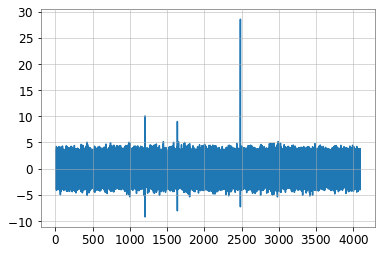

In [12]:
pylab.plot(snr.sample_times, snr)

In [13]:
import numpy as np

In [14]:
mass=np.arange(10,51)
conditioned = data
snr_max_all=[]
window = 500
for m in mass:
  hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
  mass1=m,
  mass2=m,
  delta_t=conditioned.delta_t,
  f_lower=20)
  hp.resize(len(conditioned))
  template = hp.cyclic_time_shift(hp.start_time)
  snr = matched_filter(template, conditioned, psd=psd, low_frequency_cutoff=20)
  snr = snr.crop(4 + 4, 4)

  snr_max_given_m = []
  t=0
  while t<len(snr):
    if abs(snr[t])>8:
      snr_max_given_m.append([m,snr.sample_times[t],abs(max(snr[t:t+window]))])
      t+=window
    t+=1
  snr_max_all.append(snr_max_given_m)

In [15]:
print(snr_max_all)

[[[10, 1204.7119140625, 11.405485944318617], [10, 1638.15966796875, 9.032189565219225], [10, 2483.9609375, 28.728665721066633]], [[11, 1204.71142578125, 10.836153027505366], [11, 1638.15869140625, 9.961595789599592], [11, 2483.94091796875, 10.328060000366381]], [[12, 1204.7099609375, 11.446430793376283], [12, 1638.158203125, 10.717504564680171], [12, 2483.9599609375, 8.606481481321216]], [[13, 1204.71044921875, 15.049078655562012], [13, 1638.15771484375, 13.821033696855663], [13, 2483.9599609375, 8.388667041624636]], [[14, 1204.70947265625, 12.732643952026974], [14, 1638.15673828125, 12.287361711509746], [14, 2483.9560546875, 7.74698849281953]], [[15, 1204.708984375, 17.220475887037086], [15, 1638.15576171875, 18.485491294058193]], [[16, 1204.70849609375, 18.874983463924018], [16, 1638.1552734375, 26.159058361820005]], [[17, 1204.7080078125, 16.24110675589792], [17, 1638.14892578125, 37.742702760230316], [17, 3319.25732421875, 5.727913638911416]], [[18, 1204.70703125, 16.87895734377756

In [16]:
#snr.index(max(snr[t:(t+window)]))
#max(snr[t:(t+window)])

In [17]:
c=[]
for i in range(len(snr_max_all)):
  for j in snr_max_all[i]:
    c.append(j[2])
print(c)

[11.405485944318617, 9.032189565219225, 28.728665721066633, 10.836153027505366, 9.961595789599592, 10.328060000366381, 11.446430793376283, 10.717504564680171, 8.606481481321216, 15.049078655562012, 13.821033696855663, 8.388667041624636, 12.732643952026974, 12.287361711509746, 7.74698849281953, 17.220475887037086, 18.485491294058193, 18.874983463924018, 26.159058361820005, 16.24110675589792, 37.742702760230316, 5.727913638911416, 16.878957343777564, 23.377562956077394, 17.725861000800545, 21.376432860966926, 22.009741520493524, 20.044740533873025, 36.16658945213566, 16.341838211790424, 44.64957484505665, 14.899757419449614, 5.955885057213962, 21.410658392558332, 17.200767283610613, 7.33629306998136, 19.036312539587094, 15.370442093545467, 8.17453659488107, 27.016703074562425, 19.535862555575992, 5.290438192781806, 8.880018958549966, 7.762986020656159, 22.352312137271003, 11.298266440181061, 8.656701030257786, 8.655996680552004, 6.2793897354427735, 27.804700088267797, 16.64979655374306, 

In [21]:
a = []
t=0
while t<len(snr):
  if abs(snr[t])>8:
    #x = snr[t:t+500].index(max(snr[t:t+500]))
    x = np.where(snr == max(snr[t:t+500]))
    a.append([m,snr.sample_times[x],snr.sample_times[t],snr.sample_times[t+500],abs(max(snr[t:t+500]))])
    t+=500
  t+=1
#snr.index(max(snr[t:(t+window)]))
#max(snr[t:(t+window)])
a

[[10,
  array([], dtype=float64),
  1204.7119140625,
  1204.9560546875,
  11.405485944318617],
 [10,
  array([], dtype=float64),
  1638.15966796875,
  1638.40380859375,
  9.032189565219225],
 [10,
  array([], dtype=float64),
  2483.9609375,
  2484.205078125,
  28.728665721066633]]

## Challenge 3 L1 data

In [24]:
pycbc_strain_3_L = frame.read_frame('challenge3.gwf.1', 'L1:CHALLENGE3')

In [25]:
gwpy_strain_3_gwpy_L = TimeSeries.read('challenge3.gwf.1', channel="L1:CHALLENGE3")

In [26]:
gwpy_strain_3_gwpy_L_q = gwpy_strain_3_gwpy_L.q_transform(frange=(10, 512),qrange=(8,8))

Text(0, 0.5, 'Frequency (Hz)')

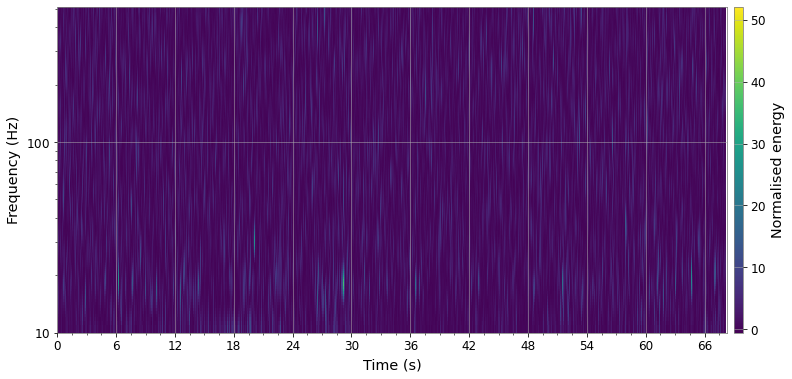

In [27]:
plot = gwpy_strain_3_gwpy_L_q.plot()
ax = plot.gca()
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (Hz)')

In [29]:
ts_2 = pycbc_strain_3_L
data_2 = resample_to_delta_t(ts_2, 1.0/2048)

p = data_2.psd(2)
p = interpolate(p, data_2.delta_f)
p = inverse_spectrum_truncation(p, int(2 * data_2.sample_rate), low_frequency_cutoff=15.0)
psd = p

In [31]:
mass=np.arange(10,51)
conditioned_2 = data_2
snr_max_all_2=[]
window = 500
for m in mass:
  hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
  mass1=m,
  mass2=m,
  delta_t=conditioned_2.delta_t,
  f_lower=20)
  hp.resize(len(conditioned_2))
  template = hp.cyclic_time_shift(hp.start_time)
  snr = matched_filter(template, conditioned_2, psd=psd, low_frequency_cutoff=20)
  snr = snr.crop(4 + 4, 4)

  snr_max_given_m_2 = []
  t=0
  while t<len(snr):
    if abs(snr[t])>8:
      snr_max_given_m_2.append([m,snr.sample_times[t],abs(max(snr[t:t+window]))])
      t+=window
    t+=1
  snr_max_all_2.append(snr_max_given_m_2)

In [33]:
print(snr_max_all)
print(snr_max_all_2)

[[[10, 1204.7119140625, 11.405485944318617], [10, 1638.15966796875, 9.032189565219225], [10, 2483.9609375, 28.728665721066633]], [[11, 1204.71142578125, 10.836153027505366], [11, 1638.15869140625, 9.961595789599592], [11, 2483.94091796875, 10.328060000366381]], [[12, 1204.7099609375, 11.446430793376283], [12, 1638.158203125, 10.717504564680171], [12, 2483.9599609375, 8.606481481321216]], [[13, 1204.71044921875, 15.049078655562012], [13, 1638.15771484375, 13.821033696855663], [13, 2483.9599609375, 8.388667041624636]], [[14, 1204.70947265625, 12.732643952026974], [14, 1638.15673828125, 12.287361711509746], [14, 2483.9560546875, 7.74698849281953]], [[15, 1204.708984375, 17.220475887037086], [15, 1638.15576171875, 18.485491294058193]], [[16, 1204.70849609375, 18.874983463924018], [16, 1638.1552734375, 26.159058361820005]], [[17, 1204.7080078125, 16.24110675589792], [17, 1638.14892578125, 37.742702760230316], [17, 3319.25732421875, 5.727913638911416]], [[18, 1204.70703125, 16.87895734377756

In [36]:
snr_max_all_sorted = []
snr_max_all_2_sorted =[]

for i in range(len(snr_max_all)):
  for j in snr_max_all[i]:
    snr_max_all_sorted.append(j[2])

for i in range(len(snr_max_all_2)):
  for j in snr_max_all_2[i]:
    snr_max_all_2_sorted.append(j[2])

snr_max_all_sorted.sort(reverse=True)
snr_max_all_2_sorted.sort(reverse=True)

print(snr_max_all_sorted)
print(snr_max_all_2_sorted)

[44.64957484505665, 37.742702760230316, 36.16658945213566, 28.728665721066633, 27.804700088267797, 27.016703074562425, 26.572193357635204, 26.456891530000643, 26.159058361820005, 26.15118690287385, 25.57145892176494, 25.4007065042676, 25.09459722239598, 24.706601085704772, 24.113359345068684, 23.983420256973584, 23.775354235728066, 23.377562956077394, 23.29115375442538, 22.750359571473062, 22.352312137271003, 22.009741520493524, 21.52583586102159, 21.410658392558332, 21.376432860966926, 20.732911584687017, 20.50798251683473, 20.234201109809966, 20.044740533873025, 19.847797564239045, 19.546187347553914, 19.535862555575992, 19.036312539587094, 18.941060628908467, 18.874983463924018, 18.598861113816483, 18.509585231220107, 18.485491294058193, 18.330949411343894, 18.080463038742938, 18.0801348300957, 17.902153778153114, 17.725861000800545, 17.468196295944328, 17.44569341214161, 17.385696284271663, 17.256549903367002, 17.220475887037086, 17.200767283610613, 17.183164502495437, 17.140853351

In [37]:
snr_max_all_unnested=[]
snr_max_all_2_unnested=[]

for i in range(len(snr_max_all)):
  for j in snr_max_all[i]:
    snr_max_all_unnested.append(j)

for i in range(len(snr_max_all_2)):
  for j in snr_max_all_2[i]:
    snr_max_all_2_unnested.append(j)

In [44]:
snr_max_all_unnested.sort(key = lambda tup: tup[1])

In [51]:
snr_max_all_unnested.index([24, 987.69287109375, 7.33629306998136])
sum=0
bruh = []
for i in snr_max_all_unnested[0:26]:
  sum += i[1]
  bruh.append(i[2])
print(sum/26)
print(max(bruh))

987.6619779146635
11.77411818526205


## Challenge 4

In [88]:
''' ! pip install -q lalsuite==6.82 bilby==1.0.4 gwpy==2.0.2 matplotlib==3.2.2 dynesty==1.0.0
from __future__ import division, print_function
import bilby
from bilby.core.prior import Uniform
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters
from gwpy.timeseries import TimeSeries '''

' ! pip install -q lalsuite==6.82 bilby==1.0.4 gwpy==2.0.2 matplotlib==3.2.2 dynesty==1.0.0\nfrom __future__ import division, print_function\nimport bilby\nfrom bilby.core.prior import Uniform\nfrom bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters\nfrom gwpy.timeseries import TimeSeries '

In [89]:
''' file_name = 'challenge3.gwf.1'
duration = 4
mass_all = [22 , 17, 10]
times_all = [1204.6943359375 , 1638.1416015625 , 2483.94091796875]
post_trigger_duration = 2
time_of_event = times_all[0]
mass = mass_all[0]
analysis_start = time_of_event + post_trigger_duration - duration
print('load data @ t:', analysis_start, analysis_start + duration)

H1 = bilby.gw.detector.get_empty_interferometer("H1")
L1 = bilby.gw.detector.get_empty_interferometer("L1")

H1_analysis_data = TimeSeries.read(file_name, 'H1:CHALLENGE3', analysis_start, analysis_start + duration)
L1_analysis_data = TimeSeries.read(file_name, 'L1:CHALLENGE3', analysis_start, analysis_start + duration)
H1.set_strain_data_from_gwpy_timeseries(H1_analysis_data)
L1.set_strain_data_from_gwpy_timeseries(L1_analysis_data)

# psd
psd_duration = duration * 32
psd_start_time = analysis_start - psd_duration
print('load psd @ t:', psd_start_time, psd_start_time + psd_duration)

H1_psd_data = TimeSeries.read(file_name, 'H1:CHALLENGE3', psd_start_time, psd_start_time + psd_duration)
L1_psd_data = TimeSeries.read(file_name, 'L1:CHALLENGE3', psd_start_time, psd_start_time + psd_duration)

psd_alpha = 2 * H1.strain_data.roll_off / duration
H1_psd = H1_psd_data.psd(fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median")
L1_psd = L1_psd_data.psd(fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median")

H1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
            frequency_array=H1_psd.frequencies.value, psd_array=H1_psd.value)
L1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
            frequency_array=H1_psd.frequencies.value, psd_array=L1_psd.value)

H1.maximum_frequency = 1024  # avoid artifacts
L1.maximum_frequency = 1024


#priors
prior = bilby.core.prior.PriorDict()
prior['chirp_mass'] = Uniform(name='chirp_mass', minimum=mass-2,maximum=mass+2)
prior['mass_ratio'] = Uniform(name='mass_ratio', minimum=0.99, maximum=1)
prior['phase'] = Uniform(name="phase", minimum=0, maximum=2*np.pi)
prior['geocent_time'] = Uniform(name="geocent_time", minimum=time_of_event-0.1, maximum=time_of_event+0.1)
prior['a_1'] =  0.0
prior['a_2'] =  0.0
prior['tilt_1'] =  0.0
prior['tilt_2'] =  0.0
prior['phi_12'] =  0.0
prior['phi_jl'] =  0.0
prior['dec'] =  -1.2232
prior['ra'] =  2.19432
prior['theta_jn'] =  1.89694
prior['psi'] =  0.532268
prior['luminosity_distance'] = 412.066


# First, put our "data" created above into a list of interferometers (the order is arbitrary)
interferometers = [H1, L1]

# Next create a dictionary of arguments which we pass into the LALSimulation waveform - we specify the waveform approximant here
waveform_arguments = dict(
    waveform_approximant='IMRPhenomPv2', reference_frequency=100., catch_waveform_errors=True)

# Next, create a waveform_generator object. This wraps up some of the jobs of converting between parameters etc
waveform_generator = bilby.gw.WaveformGenerator(
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    waveform_arguments=waveform_arguments,
    parameter_conversion=convert_to_lal_binary_black_hole_parameters)

# Finally, create our likelihood, passing in what is needed to get going
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers, waveform_generator, priors=prior,
    time_marginalization=True, phase_marginalization=True, distance_marginalization=False)

result = bilby.run_sampler(
        likelihood, prior, sampler='dynesty',outdir='short', label="GW150914",
        conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
        sample="rwalk", nact=1, walks=1, nlive=500, dlogz=0.2#, verbose=False
) '''

' file_name = \'challenge3.gwf.1\'\nduration = 4\nmass_all = [22 , 17, 10]\ntimes_all = [1204.6943359375 , 1638.1416015625 , 2483.94091796875]\npost_trigger_duration = 2\ntime_of_event = times_all[0]\nmass = mass_all[0]\nanalysis_start = time_of_event + post_trigger_duration - duration\nprint(\'load data @ t:\', analysis_start, analysis_start + duration)\n\nH1 = bilby.gw.detector.get_empty_interferometer("H1")\nL1 = bilby.gw.detector.get_empty_interferometer("L1")\n\nH1_analysis_data = TimeSeries.read(file_name, \'H1:CHALLENGE3\', analysis_start, analysis_start + duration)\nL1_analysis_data = TimeSeries.read(file_name, \'L1:CHALLENGE3\', analysis_start, analysis_start + duration)\nH1.set_strain_data_from_gwpy_timeseries(H1_analysis_data)\nL1.set_strain_data_from_gwpy_timeseries(L1_analysis_data)\n\n# psd\npsd_duration = duration * 32\npsd_start_time = analysis_start - psd_duration\nprint(\'load psd @ t:\', psd_start_time, psd_start_time + psd_duration)\n\nH1_psd_data = TimeSeries.read(